In [1]:
!pip install aix360
!pip install tensorflow==2.2.0

     |████████████████████████████████| 10.7MB 2.5MB/s 
     |████████████████████████████████| 276kB 43.1MB/s 
     |████████████████████████████████| 109.2MB 47kB/s 
     |████████████████████████████████| 276kB 47.5MB/s 
     |████████████████████████████████| 3.2MB 45.5MB/s 
     |████████████████████████████████| 51kB 6.8MB/s 
     |████████████████████████████████| 491kB 44.5MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394114 sha256=7eaa1120095870396163fac75a29d2524b0ed6498fcaba55b31adc9eed58c336
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
  Created wheel for lime: filename=lime-0.2.0.1-cp36-none-any.whl size=283845 sha256=c4591d786a0264a551c30e2ac34d8305d17a3943bca375c23711ba0a8350a0a5
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built shap lime
  Found existing installation: tensorboard 2.3.0
    Unins

In [2]:

from __future__ import print_function
import warnings
# Supress jupyter warnings if required for cleaner output
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd

import tensorflow as tf

import keras
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential # Sequeantial layer addition

from aix360.algorithms.lime import LimeImageExplainer
import aix360

# showing results
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
print("tensorflow " + tf.__version__)
print("keras " +keras.__version__)
print("aix360 " +aix360.__version__)

tensorflow 2.2.0
keras 2.4.3
aix360 0.2.0


One channel repetition

In [4]:
def to_rgb(x):
    x_rgb = np.zeros((x.shape[0], 28, 28, 3))
    for i in range(3):
        x_rgb[..., i] = x[..., 0]
    return x_rgb

In [5]:
# Load dataset
from keras.datasets import mnist
# Tuple of Numpy arrays: (x_train, y_train), (x_test, y_test).
(train, train_labels), (test, test_labels) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


# Analyzing data

In preparation in using the data we have to reshape images to 3 dimensions (height, width, canal = 1). We are adding the last dimension because Keras requires color canal at the end.

Original 1D vector consisted of 784 values(28x28). We reshape all data to 3D matrices(28x28x1) which include canal. Our canal is equal to one, because we do not have RGB colored images.

For RGB images we would reshape to 28x28x3 3D matrices, where canal would be equal to three.

In [6]:
# save input image dimensions
img_rows = train.shape[1]
img_cols = train.shape[2]

# Get classes and number of values
value_counts = pd.value_counts(train_labels).sort_index()
num_classes = value_counts.count()

Perform grayscale normalization to reduce the effect of illumination's differences and speed up the convergence of CNN.

Division by 255 is because the pixels color can range from 0 - 255.

In [7]:
train = train/255
test = test/255

Now we have to encode labels to one hot vector. Our one hot vector will be 1x10. Example for label 4: [0,0,0,1,0,0,0,0,0,0]

In [8]:
# Encode labels to one hot vectors
train_labels  = to_categorical(train_labels , num_classes = num_classes)
test_labels   = to_categorical(test_labels  , num_classes = num_classes)

# Data manipulation

In [9]:
train = train.reshape(train.shape[0], img_rows, img_cols, 1)
test = test.reshape(test.shape[0], img_rows, img_cols, 1)

In [10]:
train_rgb = to_rgb(train)
test_rgb = to_rgb(test)

# The Model
## Model creation

First step is to create empty sequential model. To the model we add 2D convolutional layer which takes the input image.

In [11]:
model = Sequential()

In [12]:
model.add(Conv2D(32, kernel_size = 4, activation="relu", input_shape=(28,28,3)))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size = 3, activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size = 2, activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.25))
model.add(Dense(10, activation='softmax'))

## Train model

In [13]:
model.compile(loss='categorical_crossentropy',
      optimizer='adam',
      metrics=['accuracy'])

In [14]:
batch_size = 128
epochs = 1

model.fit(train_rgb, train_labels,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(test_rgb, test_labels))

469/469 [==============================] - 50s 107ms/step - loss: 0.2865 - accuracy: 0.9091 - val_loss: 0.0679 - val_accuracy: 0.9771


In [15]:
pred = model.predict(test_rgb)

score = model.evaluate(test_rgb, test_labels, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.06791497766971588
Test accuracy: 0.9771000146865845


# Get errors

In [16]:
test_labels_predicted_classes = np.argmax(pred,axis = 1) 
test_true = np.argmax(test_labels,axis = 1)

In [17]:
def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 10 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 5
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(20, 8))
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1
    plt.show()

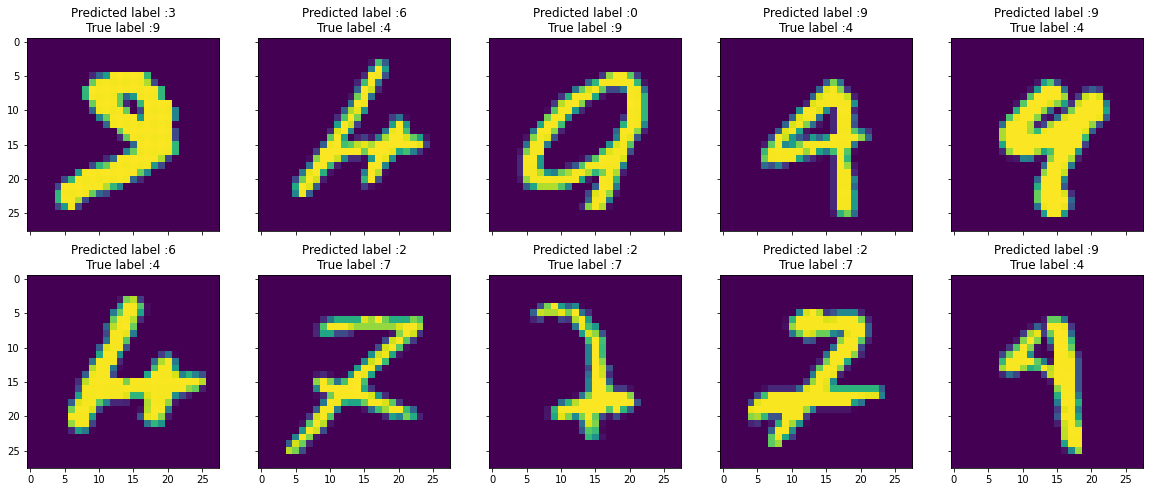

In [18]:
errors = (test_labels_predicted_classes - test_true != 0)

test_labels_classes_errors = test_labels_predicted_classes[errors]
test_labels_errors = pred[errors]
test_true_errors = test_true[errors]
test_errors = test[errors]


    
test_labels_errors_prob = np.max(test_labels_errors,axis = 1)
true_prob_errors = np.diagonal(np.take(test_labels_errors, test_true_errors, axis=1))
delta_pred_true_errors = test_labels_errors_prob - true_prob_errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)
most_important_errors = sorted_dela_errors[-10:]

display_errors(most_important_errors, test_errors, test_labels_classes_errors, test_true_errors)

# Explanation

In [19]:
#Initialize
limeExplainer = LimeImageExplainer()


Predicted label :3
True label :9
Top predictions: [3, 8, 2, 9, 5]


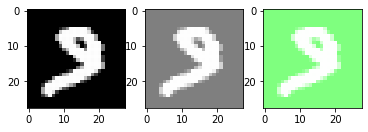

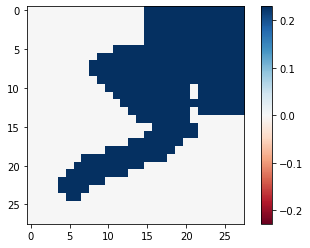


Predicted label :6
True label :4
Top predictions: [6, 4, 0, 2, 8]


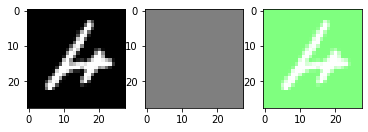

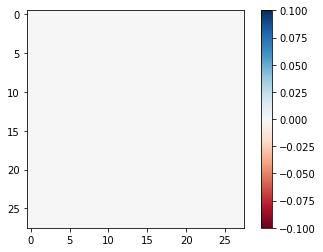


Predicted label :0
True label :9
Top predictions: [0, 9, 2, 6, 7]


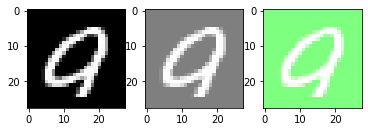

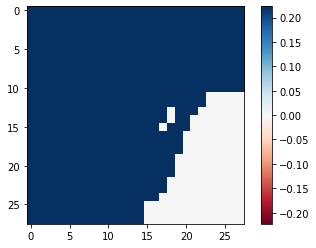


Predicted label :9
True label :4
Top predictions: [9, 4, 0, 8, 5]


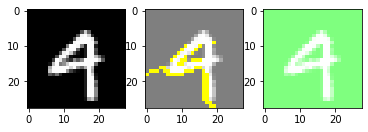

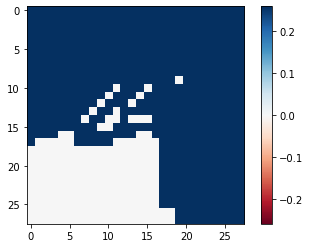


Predicted label :9
True label :4
Top predictions: [9, 4, 8, 7, 5]


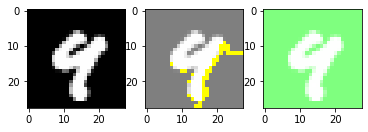

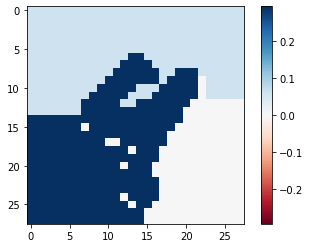


Predicted label :6
True label :4
Top predictions: [6, 4, 0, 5, 2]


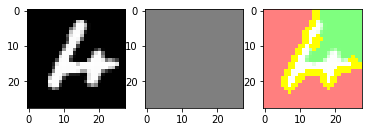

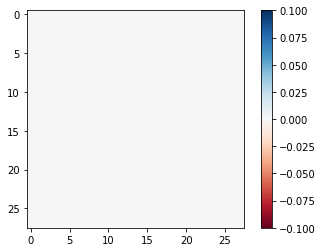


Predicted label :2
True label :7
Top predictions: [2, 3, 8, 7, 6]


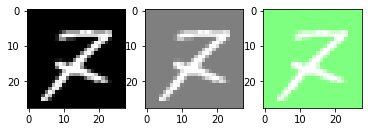

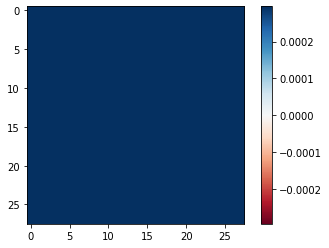


Predicted label :2
True label :7
Top predictions: [2, 1, 3, 7, 8]


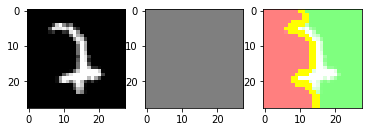

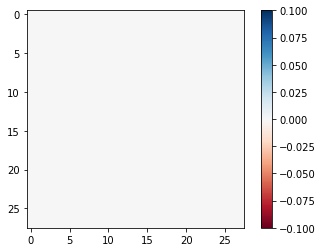


Predicted label :2
True label :7
Top predictions: [2, 3, 7, 8, 0]


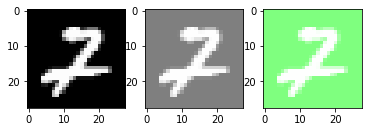

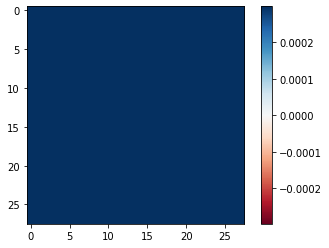


Predicted label :9
True label :4
Top predictions: [9, 4, 8, 7, 3]


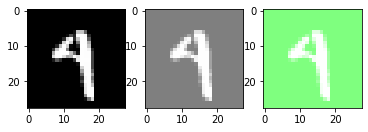

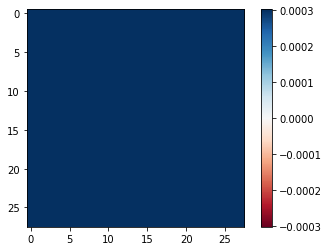

In [20]:
#Check out the 10 data that the model has mistakenly predicted.
test_errors_rgb = to_rgb(test_errors)
for i in most_important_errors:
    
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    # Explain.
    explanation = limeExplainer.explain_instance(test_errors_rgb[i], model.predict, top_labels=5, hide_color=0, num_samples=3)
    print("Predicted label :{}\nTrue label :{}".format(test_labels_classes_errors[i],test_true_errors[i]))
    # Plot original
    plt.subplot(1,3,1)
    plt.imshow(test_errors_rgb[i]) 
    
    
    #Displays the results.
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=True)
    plt.subplot(1,3,2)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask)) 
    print("Top predictions: " + str(explanation.top_labels))
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=True)
    plt.subplot(1,3,3)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

    plt.show()

    #Select the same class explained on the figures above.
    ind =  explanation.top_labels[0]

    #Map each explanation weight to the corresponding superpixel
    dict_heatmap = dict(explanation.local_exp[ind])
    heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

    #Plot. The visualization makes more sense if a symmetrical colorbar is used.
    plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
    plt.colorbar()
    plt.show()


Predicted label :7
True label :7
Top predictions: [7, 2, 1, 9, 3]


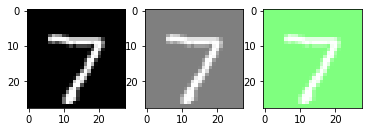

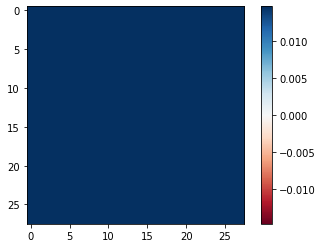


Predicted label :2
True label :2
Top predictions: [2, 0, 1, 8, 6]


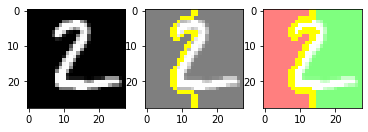

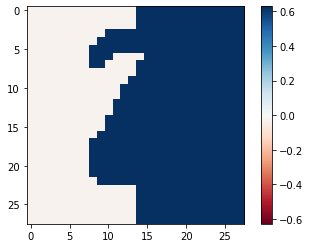


Predicted label :1
True label :1
Top predictions: [1, 7, 9, 4, 6]


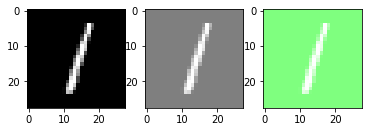

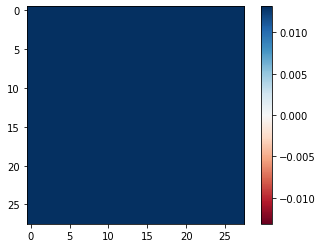


Predicted label :0
True label :0
Top predictions: [0, 6, 9, 5, 2]


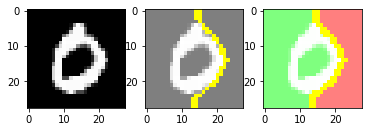

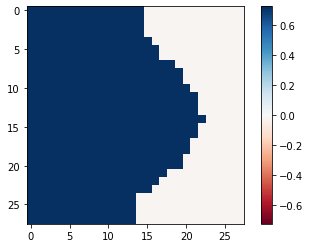


Predicted label :4
True label :4
Top predictions: [4, 9, 6, 1, 0]


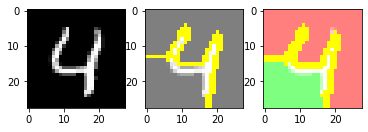

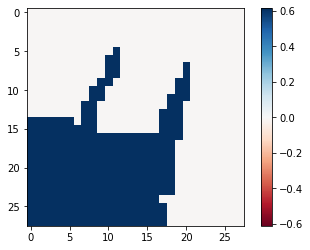


Predicted label :1
True label :1
Top predictions: [1, 7, 9, 4, 0]


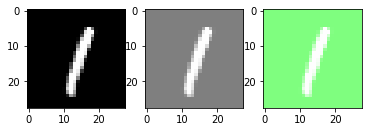

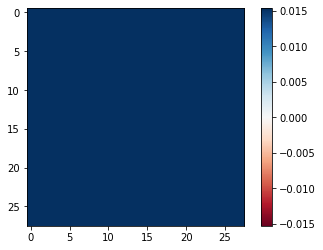


Predicted label :4
True label :4
Top predictions: [4, 9, 8, 7, 5]


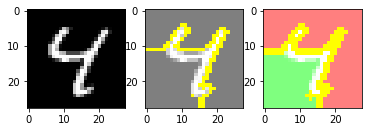

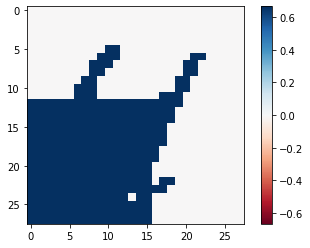


Predicted label :9
True label :9
Top predictions: [9, 8, 3, 2, 7]


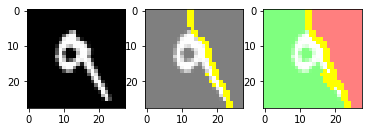

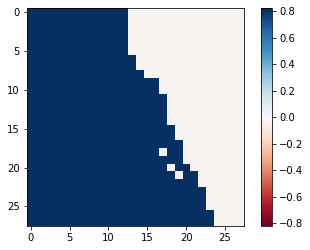


Predicted label :5
True label :5
Top predictions: [5, 6, 8, 9, 4]


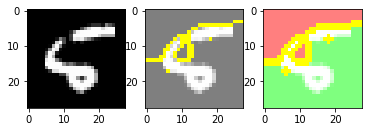

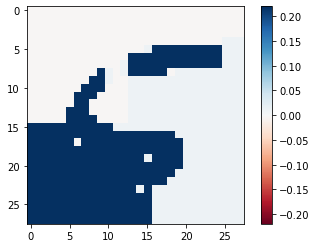


Predicted label :9
True label :9
Top predictions: [9, 8, 7, 4, 5]


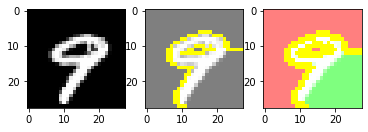

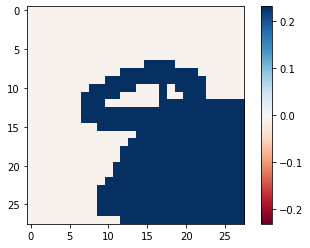

In [21]:
count = 0
for num in range(0,test.shape[0]) :
    if errors[num] == False:
        count += 1
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
       
        plt.subplot(1,3,1)
        plt.imshow(test_rgb[num]) 


        # Explain.
        explanation = limeExplainer.explain_instance(test_rgb[num], model.predict, num_samples=100)
        #Labels
        print("Predicted label :{}\nTrue label :{}".format(test_labels_predicted_classes[num],np.argmax(test_labels[num])))
        print("Top predictions: " + str(explanation.top_labels))
        
        #Displays the results.
        temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=True)
        plt.subplot(1,3,2)
        plt.imshow(mark_boundaries(temp / 2 + 0.5, mask)) 
        
        temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
        plt.subplot(1,3,3)
        plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

        plt.show()

        #Select the same class explained on the figures above.
        ind =  explanation.top_labels[0]

        #Map each explanation weight to the corresponding superpixel
        dict_heatmap = dict(explanation.local_exp[ind])
        heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

        #Plot. The visualization makes more sense if a symmetrical colorbar is used.
        plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
        plt.colorbar()
        plt.show()

        if count >= 10:
          break 